# Data Encoding and Decoding for Object Detection

As we've seen in the previous notebook one crucial step for training a network implementing SSD for object detection it's the data encoding process. During training, the network expects ground truth data for regression to be provided as offsets from these default boxes. Therefore, it's crucial to accurately transform and encode the coordinates of ground truth bounding boxes into these offsets to ensure proper network training.

## Dependecies and Parameters

Let's quickly import dependecies and define some useful parameters for this notebook.

In [2]:
# dependecies
import json
import random
import csv
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt, patches
from PIL import Image
import tensorflow as tf
import ssdseglib

# global variables
INPUT_IMAGE_SHAPE = (480, 640)
BATCH_SIZE = 8
SEED = 1993

# labels conversions
LABEL_CODE_TO_DESC = {
    1: 'monorail',
    2: 'person',
    3: 'forklift'
}
LABEL_CODE_TO_COLOR = {
    1: 'red',
    2: 'green',
    3: 'blue'
}

## Encoding Data

### Read Metadata

Read metadata (files paths locations for images and boxes coordinates).

In [3]:
# read metadata
data = []

with open('data/train.json', 'r') as f:
    data.extend(json.load(f))

with open('data/train-additional-persons.json', 'r') as f:
    data.extend(json.load(f))

with open('data/train-additional-forklifts.json', 'r') as f:
    data.extend(json.load(f))

with open('data/eval-persons-forklifts.json', 'r') as f:
    data.extend(json.load(f))    

path_files_images_train, path_files_masks_train, path_files_labels_boxes_train = map(list, zip(*data))

### Define Default Grids and Boxes

Here we define a set of default boxes, rescaling them to properly fit the input image shape.

In [4]:
# create default bounding boxes
boxes_default = ssdseglib.boxes.DefaultBoundingBoxes(
    feature_maps_shapes=((30, 40), (15, 20), (8, 10), (4, 5)),
    centers_padding_from_borders_percentage=(0.025, 0.05, 0.075, 0.1),
    boxes_scales=(0.15, 0.95),
    additional_square_box=True,
)

# scale default bounding boxes to image shape
boxes_default.rescale_boxes_coordinates(image_shape=INPUT_IMAGE_SHAPE)

### Data Encoder

This is custom class that help us reading images, boxes coordinates and properly encode them.

Keep in mind that this class when encoding data it's also encoding segmentation masks and apply some data augmentation.

In [5]:
# create a data reader encoder
data_reader_encoder = ssdseglib.datacoder.DataEncoderDecoder(
    num_classes=4,
    image_shape=INPUT_IMAGE_SHAPE,
    xmin_boxes_default=boxes_default.get_boxes_coordinates_xmin(coordinates_style='ssd'),
    ymin_boxes_default=boxes_default.get_boxes_coordinates_ymin(coordinates_style='ssd'),
    xmax_boxes_default=boxes_default.get_boxes_coordinates_xmax(coordinates_style='ssd'),
    ymax_boxes_default=boxes_default.get_boxes_coordinates_ymax(coordinates_style='ssd'),
    iou_threshold=0.525,
    standard_deviations_centroids_offsets=(0.1, 0.1, 0.2, 0.2),
    augmentation_horizontal_flip=True
)

We also define a tensorflow pipeline for load data in batches easily.

In [6]:
# sample some data randomly
random_sample = random.sample(range(len(path_files_images_train)), k=100)
path_files_images_train = np.array(path_files_images_train)[random_sample]
path_files_masks_train = np.array(path_files_masks_train)[random_sample]
path_files_labels_boxes_train = np.array(path_files_labels_boxes_train)[random_sample]

# tensorflow train dataset pipeline
ds_train = (
    tf.data.Dataset.from_tensor_slices((path_files_images_train, path_files_masks_train, path_files_labels_boxes_train))
    .map(data_reader_encoder.read_and_encode, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size=BATCH_SIZE)
    .map(ssdseglib.datacoder.augmentation_rgb_channels, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

The following 2x2 grid of plots provides a comprehensive view of the data encoding and decoding process.

1. **Ground Truth Boxes (Top Left)**
   
   This plot displays the original input image with ground truth bounding boxes on it. These bounding boxes represent the true locations of the objects in the image, annotated for reference.

2. **Matching Default Boxes (Top Right)**
   
   Here, the input image is shown with default boxes on it. The default boxes that have an Intersection over Union (IoU) above a certain threshold with the ground truth boxes are marked as matching. This visualization helps in understanding how the default boxes align with the actual object locations.

3. **Segmentation Mask (Bottom Left)**
   
   This plot shows the segmentation mask, which highlights different regions of the image corresponding to various object classes. This mask helps in visualizing how the image is segmented into different object categories.

4. **Decoded Offsets (Bottom Right)**
   
   In this plot, the offsets calculated for matching boxes are decoded back into bounding boxes. This involves translating the offset coordinates from default boxes to actual bounding boxes. The resulting plot demonstrates how well the default boxes overlap with the ground truth boxes, indicating the network's effectiveness in predicting accurate object locations. Of course in this it's a perfect match, since we are just reversing the encoding operation instead of decoding real predictions.

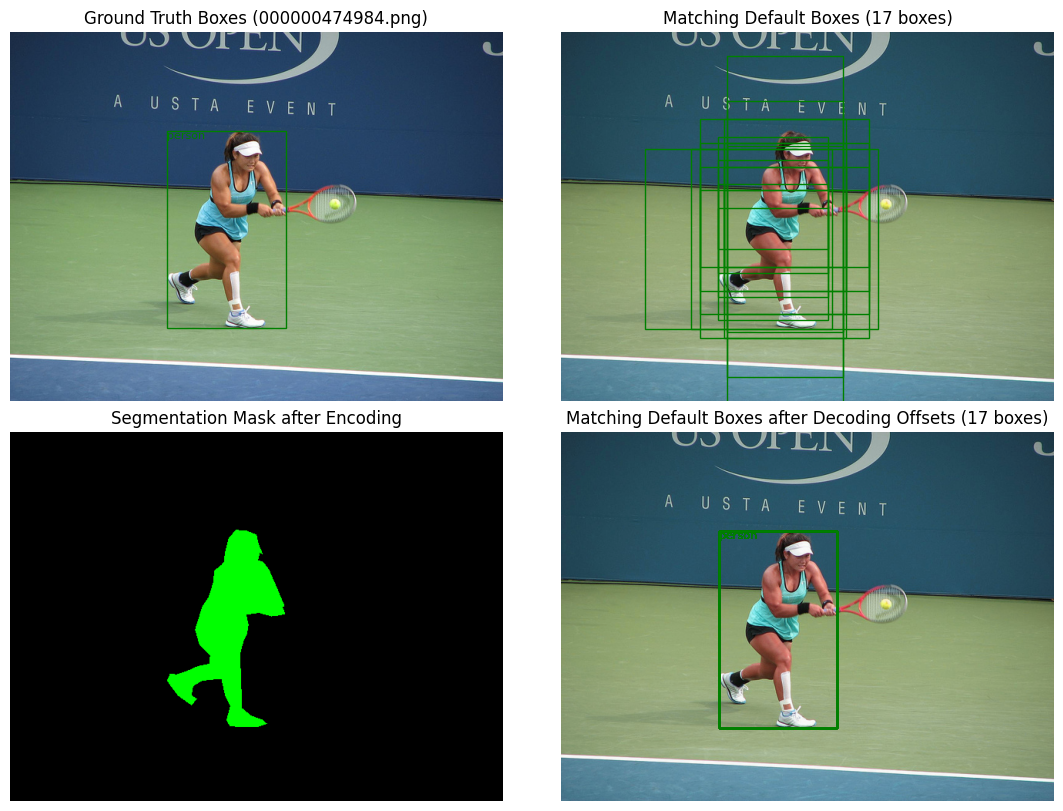

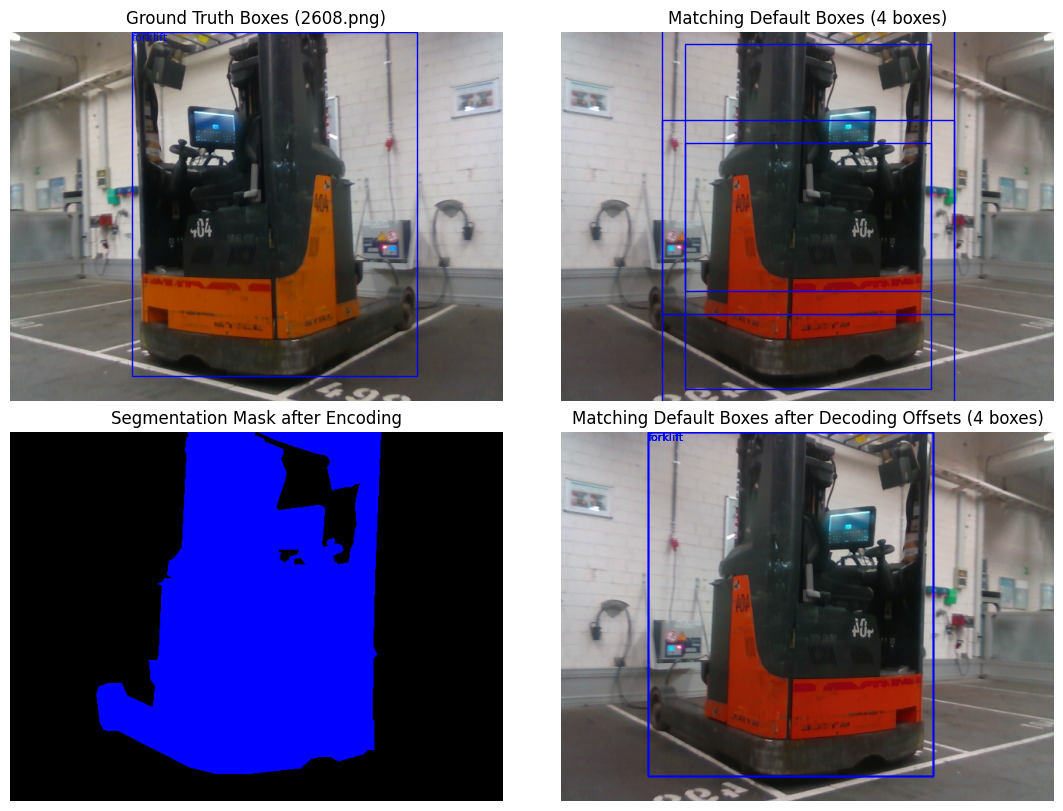

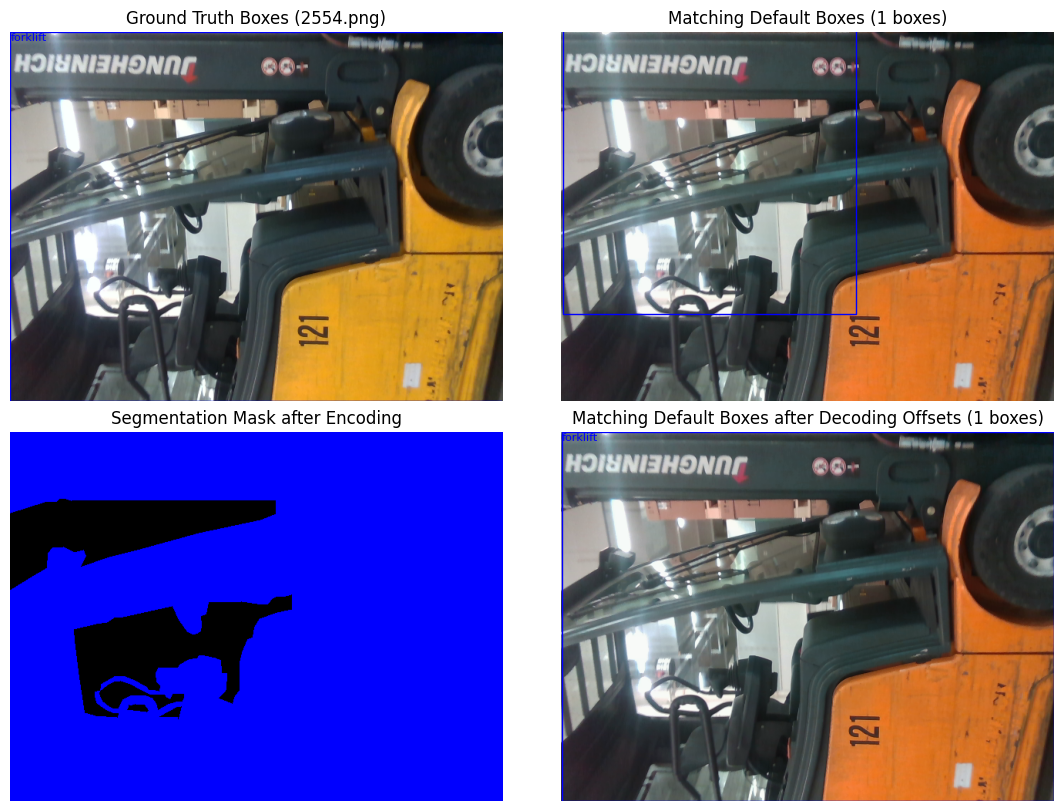

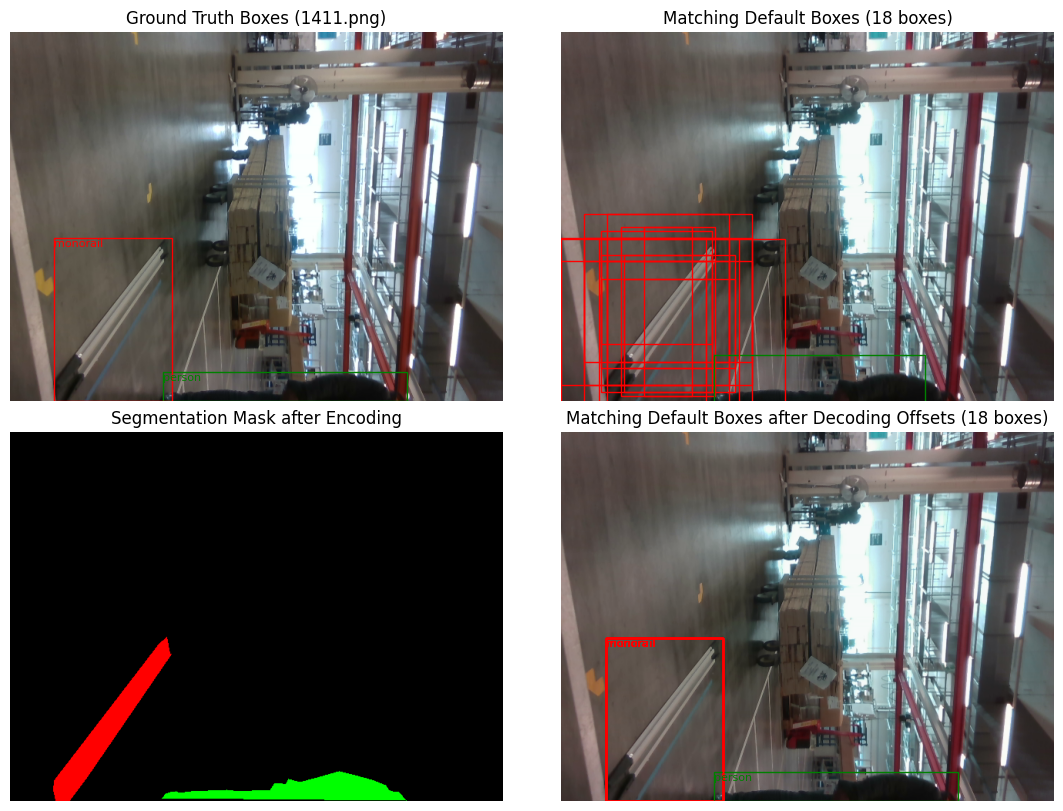

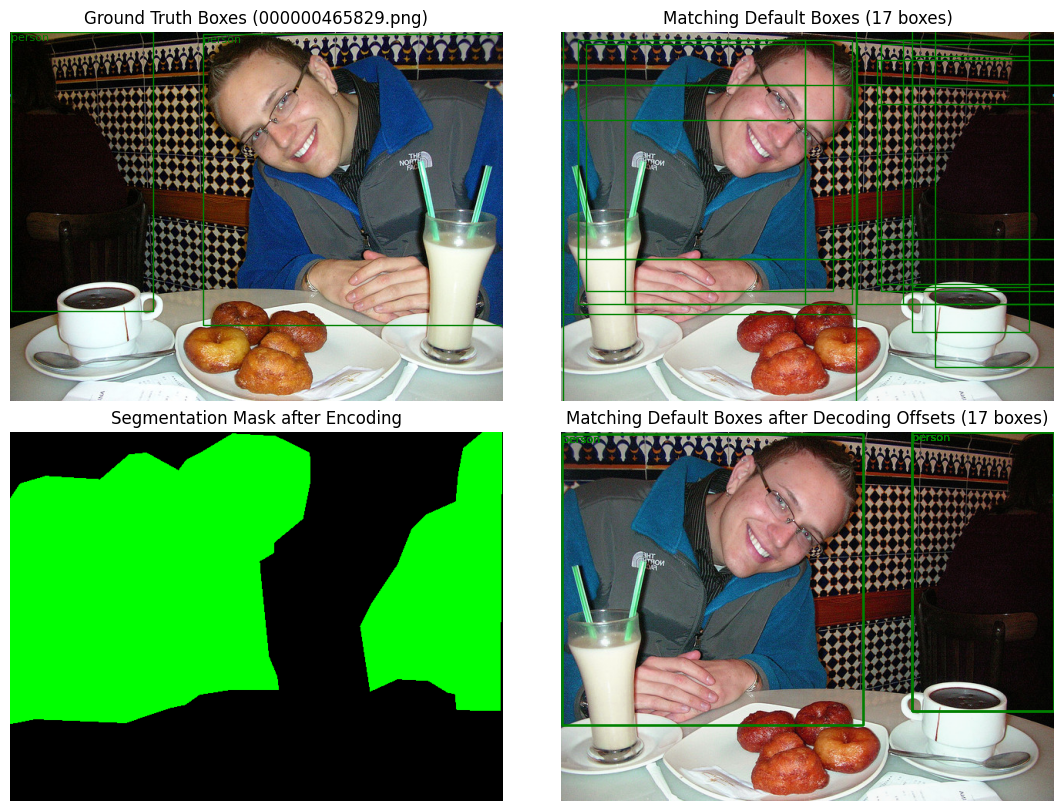

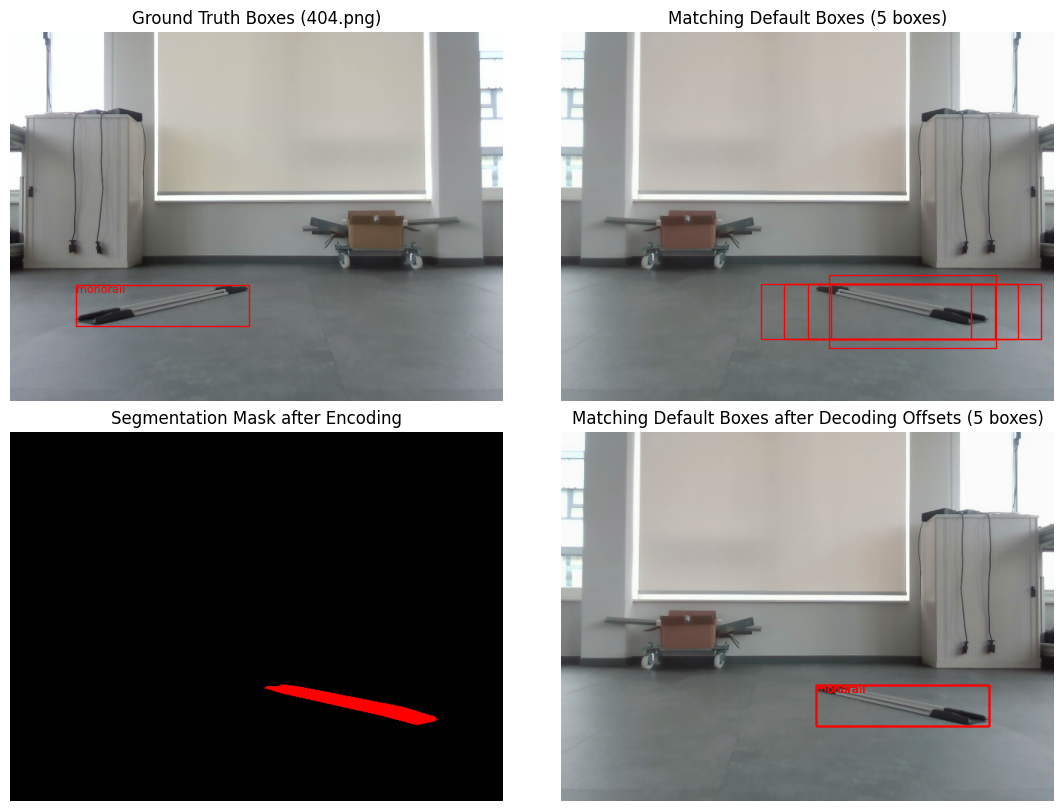

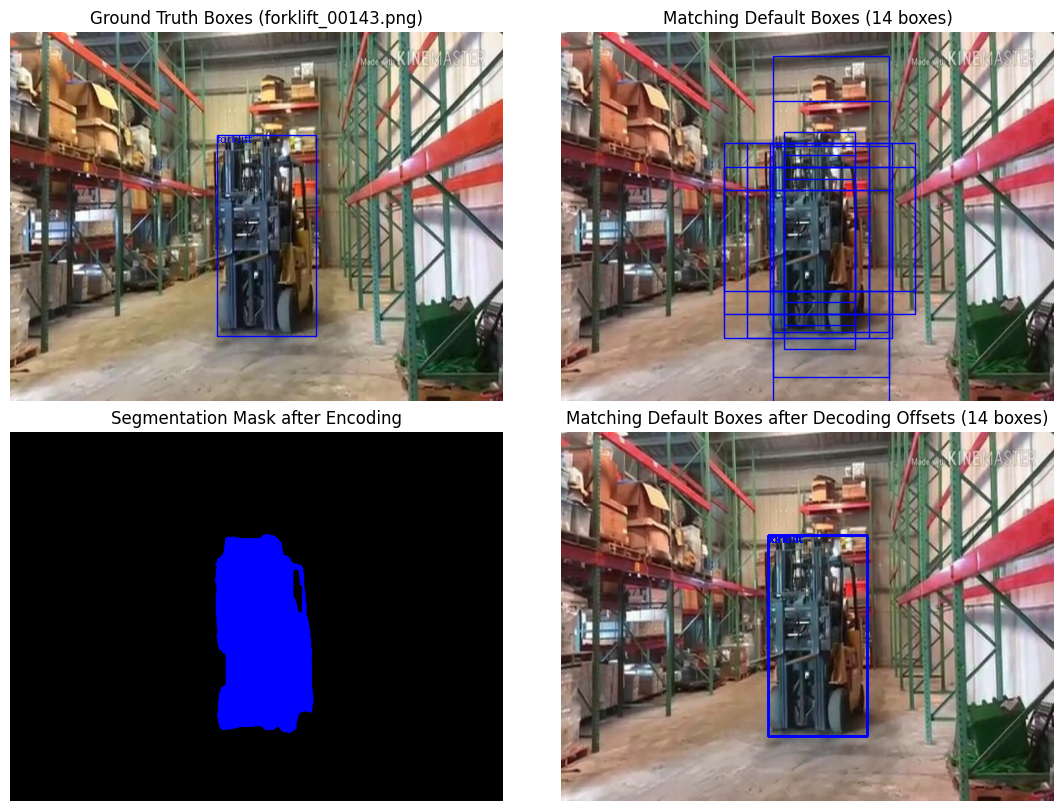

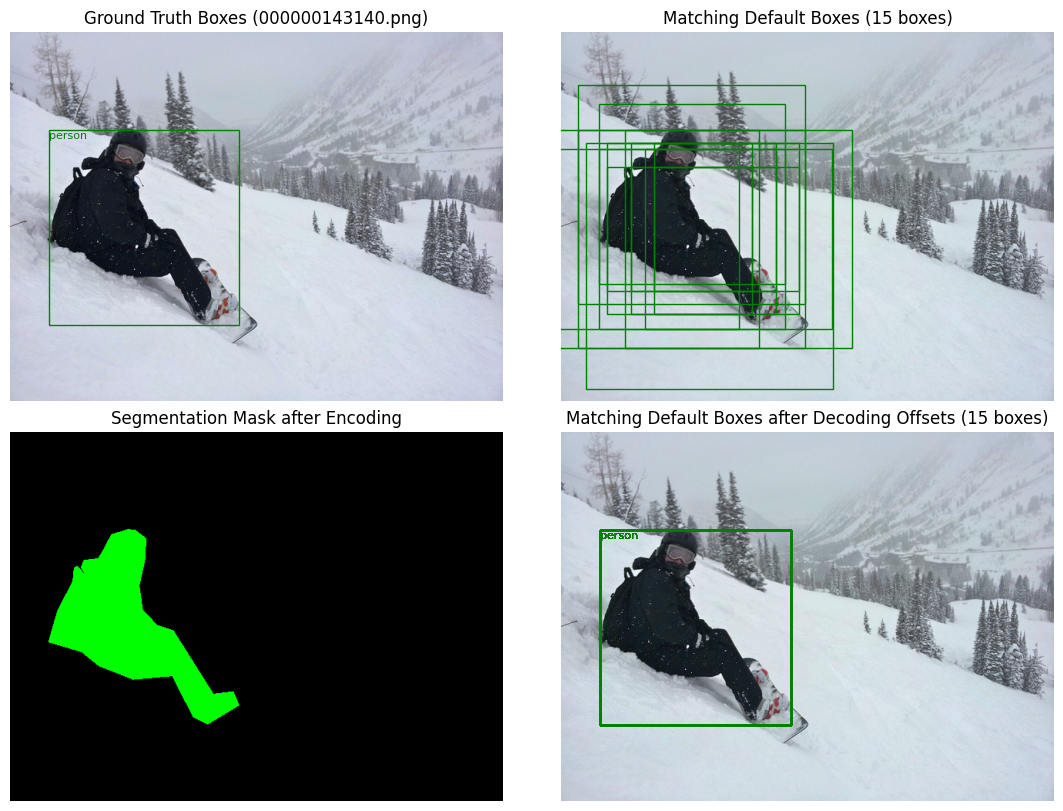

In [9]:
# sample counter (used for plot ground truth bounding boxes)
i = 0

# figure size
fig_size_width = 11

# check if data it's read, encoded and decoded properly
for image_batch, targets_batch in ds_train.take(1):
    for image_sample, mask_sample, labels_sample, boxes_sample in zip(image_batch, targets_batch['output-mask'], targets_batch['output-labels'], targets_batch['output-boxes']):
        
        # read labels boxes from csv file, this is for ground truth
        with open(path_files_labels_boxes_train[i], 'r') as f:
            labels_boxes = list(csv.reader(f))

        # create the needed subplots and set figure size
        fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(nrows=2, ncols=2,  constrained_layout=True)        
        fig.set_size_inches(fig_size_width, int(fig_size_width / (INPUT_IMAGE_SHAPE[1] / INPUT_IMAGE_SHAPE[0])))
        
        # ------------------------------------------------------------------------------------------------------------------
        # ground truth - bounding boxes
        # ------------------------------------------------------------------------------------------------------------------
        # this is useful to see the original data, untouched by the tensorflow data pipeline

        # read ground truth image        
        image = Image.open(path_files_images_train[i])
        image = np.array(image)
        image = image.astype(np.int32)

        # setup the subplot
        ax1.set_aspect('equal')
        ax1.imshow(image, vmin=0, vmax=255)
        ax1.set_axis_off()
        ax1.set_title(f'Ground Truth Boxes ({Path(path_files_images_train[i]).name})')

        # plot ground truth boxes
        for label, xmin, ymin, xmax, ymax in labels_boxes:
            label = int(label)
            xmin = float(xmin)
            ymin = float(ymin)
            xmax = float(xmax)
            ymax = float(ymax)        
            rect = patches.Rectangle((xmin, ymin), xmax - xmin + 1, ymax - ymin + 1, linewidth=1, edgecolor=LABEL_CODE_TO_COLOR[label], facecolor='none')
            ax1.add_patch(rect)
            ax1.text(xmin, ymin, LABEL_CODE_TO_DESC[label], fontsize=8, color=LABEL_CODE_TO_COLOR[label], verticalalignment='top')        

        # ------------------------------------------------------------------------------------------------------------------
        # encoded masks - semantic segmentation mask
        # ------------------------------------------------------------------------------------------------------------------
        # remove the background class and keep the other 3 classes on rgb channels
        mask_sample = tf.slice(mask_sample, begin=[0, 0, 1], size=[-1, -1, 3])

        # setup the subplot
        ax2.set_aspect('equal')
        ax2.imshow(mask_sample, vmin=0.0, vmax=1.0)
        ax2.set_axis_off()
        ax2.set_title('Segmentation Mask after Encoding')

        # ------------------------------------------------------------------------------------------------------------------
        # decoded boxes - show the matched boxes after the encoding decoding process
        # ------------------------------------------------------------------------------------------------------------------
        # this subplot it's very important because it can easily show if the encoding decoding process was done properly or not
        # if some default bounding boxes were matched with ground truth boxes and properly encoded,
        # then through decoding process we should get back coordinates for the original ground truth boxes
        # basically the decoded boxes should match the ground truth ones

        # use the one-hot-encoded labels to create a boolean vector for select items not related to background class
        not_background = tf.math.equal(labels_sample[:, 0], 0.0)

        # keep only decoded boxes not related to background class
        decoded_boxes = data_reader_encoder.decode_to_corners(offsets_centroids=boxes_sample)
        decoded_boxes_sample_not_background = tf.boolean_mask(
            tensor=decoded_boxes,
            mask=not_background,
            axis=0
        )

        # keep only corresponding labels not related to background class
        valid_labels_sample = tf.boolean_mask(
            tensor=labels_sample,
            mask=not_background,
            axis=0
        )

        # setup subplot
        ax4.set_aspect('equal')
        ax4.imshow(tf.cast(image_sample, tf.int32), vmin=0, vmax=255)
        ax4.set_axis_off()
        ax4.set_title(f'Matching Default Boxes after Decoding Offsets ({decoded_boxes_sample_not_background.shape[0]} boxes)')

        # plot decoded boxes
        for labels_one_hot_encoded, (xmin, ymin, xmax, ymax) in zip(valid_labels_sample, decoded_boxes_sample_not_background):
            label = int(tf.argmax(labels_one_hot_encoded))
            xmin = float(xmin)
            ymin = float(ymin)
            xmax = float(xmax)
            ymax = float(ymax)            
            rect = patches.Rectangle((xmin, ymin), xmax - xmin + 1, ymax - ymin + 1, linewidth=1, edgecolor=LABEL_CODE_TO_COLOR[label], facecolor='none')
            ax4.add_patch(rect)
            ax4.text(xmin, ymin, LABEL_CODE_TO_DESC[label], fontsize=8, color=LABEL_CODE_TO_COLOR[label], verticalalignment='top')

        # ------------------------------------------------------------------------------------------------------------------
        # default bounding boxe boxes - show the matched default bounding boxes
        # ------------------------------------------------------------------------------------------------------------------
        # this is just for fun :)

        # keep default bounding boxes not related to background class 
        default_boxes_sample_not_background = tf.concat(
            values=[
                tf.expand_dims(input=tf.boolean_mask(tensor=data_reader_encoder.xmin_boxes_default, mask=not_background, axis=0), axis=1),
                tf.expand_dims(input=tf.boolean_mask(tensor=data_reader_encoder.ymin_boxes_default, mask=not_background, axis=0), axis=1),
                tf.expand_dims(input=tf.boolean_mask(tensor=data_reader_encoder.xmax_boxes_default, mask=not_background, axis=0), axis=1),
                tf.expand_dims(input=tf.boolean_mask(tensor=data_reader_encoder.ymax_boxes_default, mask=not_background, axis=0), axis=1),
            ],
            axis=1
        )

        # setup subplot
        ax3.set_aspect('equal')
        ax3.imshow(tf.cast(image_sample, tf.int32), vmin=0, vmax=255)
        ax3.set_axis_off()
        ax3.set_title(f'Matching Default Boxes ({default_boxes_sample_not_background.shape[0]} boxes)')

        # plot default bounding boxes
        for labels_one_hot_encoded, (xmin, ymin, xmax, ymax) in zip(valid_labels_sample, default_boxes_sample_not_background):
            label = int(tf.argmax(labels_one_hot_encoded))
            xmin = float(xmin)
            ymin = float(ymin)
            xmax = float(xmax)
            ymax = float(ymax)            
            rect = patches.Rectangle((xmin, ymin), xmax - xmin + 1, ymax - ymin + 1, linewidth=1, edgecolor=LABEL_CODE_TO_COLOR[label], facecolor='none')
            ax3.add_patch(rect)

        # show the figure
        plt.show()

        # sample counter (used for plot ground truth bounding boxes)
        i += 1